In [1]:
from pearlsim.results_processing import *
from pearlsim.ml_utilities import extract_from_bumat
from pearlsim.material import Material
from pearlsim.serpent_spectrum_tools import *
import matplotlib.pyplot as plot
import numpy as np
import pandas as pd
import os
import json
import time
from numpy.random import poisson

In [2]:
working_directory = "gFHR_equilibrium"
simulation_name = "gFHR_equilibrium_<iteration>.serpent"
parameters_to_extract = ["ANA_KEFF"]
num_steps = 200
num_substeps = 1
dep_step = 6.525
decay_days = 1.0
PEBBLE_FUEL_VOLUME = 0.36263376
gamma_processing = "Serpent"
detector_response_matrix_path = "detector_data/detector_response_mat.npy"
detector_energy_grid_path = "detector_data/detector_e_grid.npy"
decay_template_path = "decay_step1_template.serpent"
gamma_template_path = "decay_step2_template.serpent"
decay_point_path = "decay.points"

In [3]:
detector_matrix = np.load(detector_response_matrix_path)
detector_energy_grid = np.load(detector_energy_grid_path)

In [4]:
simulation_data = {}
total_days = 0
for i in range(1,1+num_steps):
    total_days += dep_step
    serp_file = simulation_name.replace("<iteration>", str(i))
    res_file_name = f"{working_directory}/{serp_file}_res.m"
    step_results = {}
    for parameter in parameters_to_extract:
        value, unc = read_res_file(res_file_name, parameter)
        step_results[parameter] = value
    det_file_name = f"{working_directory}/{serp_file}_det0.m"
    core_flux, core_flux_unc = read_core_flux(det_file_name, normalize_and_label=True)
    discharge_file_names = []
    discard_file_names = []
    for sub_step in range(1,1+num_substeps):
        discharge_file_name = f"discharge_pebbles_{i}_{sub_step}.json"
        discharge_file_names += [discharge_file_name]
        discard_file_name = f"discard_pebbles_{i}_{sub_step}.json"
        discard_file_names += [discard_file_name]
    simulation_data[str(i)] = {"total_days": total_days,
                     "results": step_results,
                     "core_flux": core_flux.iloc[0].to_dict(),
                     "discharge_files": discharge_file_names,
                     "energy_grid": detector_energy_grid.tolist(),
                     "operating_parameters": 
                          {
                              "power": 280e6,
                              "threshold": 72 # passes
                          },
                     "discard_files": discard_file_names}

In [5]:
def compute_average_distributions(bumat_file_name, zone_file_name, discharge_files, isotope, 
                                  top_zones, base_fuel_name="fuel20", num_passes=8):
    concentrations = extract_from_bumat(bumat_file_name, return_list=False)
    pass_counts = np.zeros(num_passes)
    average_concentrations = np.zeros(num_passes)
    pebble_distributions = []
    with open(zone_file_name, 'r') as f:
        zone_map = json.load(f)
    for pass_num in range(1,1+num_passes):
        for zone in top_zones:
            fuel_name = f"{base_fuel_name}_{zone}P{pass_num}"
            pass_counts[pass_num-1] += zone_map["zone"+zone][fuel_name]
            average_concentrations[pass_num-1] += zone_map["zone"+zone][fuel_name]*concentrations[fuel_name][isotope]
        average_concentrations[pass_num-1] /= pass_counts[pass_num-1]
    for file_name in discharge_files:
        with open(file_name, 'r') as f:
            discharge_data = json.load(f)
        for key in discharge_data.keys():
            pebble_distributions += [discharge_data[key]['concentration'][isotope]]
    return average_concentrations, pebble_distributions


top_zones = ["R1Z10","R2Z10", "R3Z10", "R4Z10"]
avg, dist = compute_average_distributions(f"gFHR_equilibrium/gFHR_equilibrium_1.serpent.bumat1",
                             "gFHR_equilibrium/zone_map3.json", 
                              ["gFHR_equilibrium/discharge_pebbles_60_1.json"], 
                              "55135<lib>", top_zones)
        
        

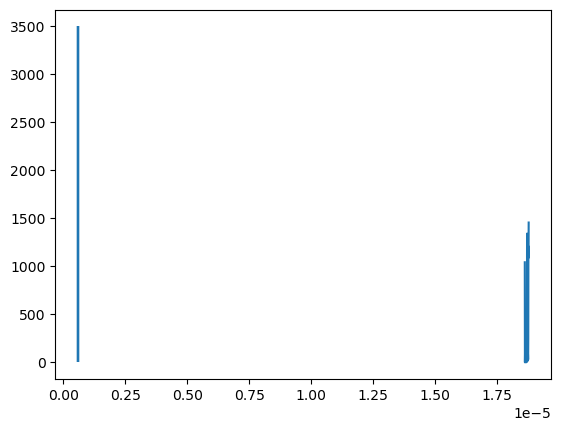

In [6]:
counts, bins = np.histogram(dist,  bins=30)
bin_centers = (bins[1:]-bins[:1])/2
plot.figure()
plot.plot(bins[1:], counts)
for pass_avg in avg:
    plot.vlines(pass_avg,0,3500)

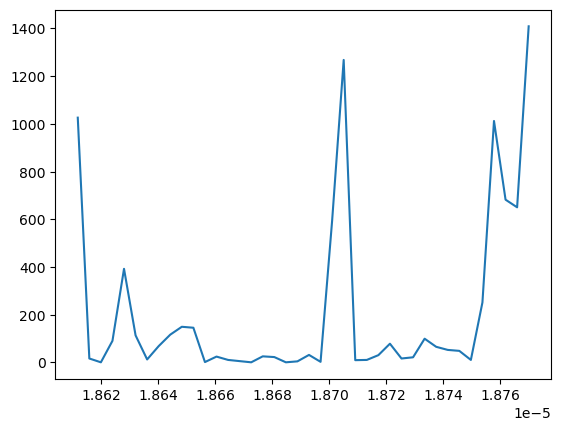

In [7]:
counts, bins = np.histogram(dist,  bins=40)
bin_centers = (bins[1:]-bins[:1])/2
plot.figure()
plot.plot(bins[1:], counts)
#for pass_avg in avg:
#    plot.vlines(pass_avg,0,3500)

# FIER Setup Block
Ensure that FIER is ready to run if it is your choice of gamma processor

In [8]:
if gamma_processing == "FIER":
    
    # Download and compile FIER if not already done
    if not os.path.isdir("FIER"):
        os.system("git clone https://github.com/efmatthews/FIER.git")
        os.chdir("FIER/FIER")
        os.mkdir("output")
        os.system(f"g++ -std=c++11 *.cpp -o fier.exe")
    else:
        os.chdir("FIER/FIER")
os.chdir("../..")

In [9]:
os.chdir("/global/scratch/users/ikolaja/PEARLSim")
for sim_key in simulation_data.keys():
        discharge_files = simulation_data[sim_key]["discharge_files"]
        for sub_step in range(num_substeps):
            file = discharge_files[sub_step]
            with open(f"{working_directory}/{file}", 'r') as f:
                pebble_data = json.load(f)
        

            for pebble_ind in pebble_data.keys():
                if pebble_ind == '0':
                    conc_dict = {}
                    for iso_key in pebble_data['0']['concentration'].keys():
                        conc_dict[iso_key] = []
                for iso_key in pebble_data[pebble_ind]['concentration'].keys():
                    conc_dict[iso_key] += [pebble_data[pebble_ind]['concentration'][iso_key]]
            conc_df = pd.DataFrame(conc_dict)
            if gamma_processing == "FIER":
                os.chdir("FIER/FIER")
                create_spectra_with_FIER(conc_df, detector_energy_grid, decay_days, delete_inputs = True)
            if gamma_processing == "Serpent":
                os.chdir(working_directory)
                display(conc_df)
                emitted_spectra = create_spectra_with_serpent(conc_df, "../"+decay_template_path, "../"+gamma_template_path, "../"+decay_point_path,
                                detector_energy_grid, decay_days, 24, f"{sim_key}_{sub_step+1}")
                os.chdir("..")
            for pebble_ind in pebble_data.keys():
                try:
                    pebble_data[pebble_ind].pop("concentration")
                except:
                    pass 
                #pebble_data[pebble_ind][f'emitted_spectrum_{round(decay_days,1)}d'] = emitted_spectra['decay'+pebble_ind]
                emitted_spectrum = emitted_spectra['decay'+pebble_ind]
                sampled_spectrum = poisson(emitted_spectrum) #(pebble_data[pebble_ind][f'emitted_spectrum_{decay_days}d'])
                detected_spectrum = poisson(detector_matrix @ sampled_spectrum).astype(float)
                pebble_data[pebble_ind][f'detected_spectrum_{round(decay_days,1)}d'] = getattr(detected_spectrum, "tolist", lambda: detected_spectrum)()
            with open(f"{working_directory}/discharge_pebbles_{sim_key}_{sub_step+1}_processed.json", 'w') as file:
                json.dump(pebble_data, file, indent=2)

,10010,10020,10030,20030,20040,20060,3006<lib>,3007<lib>,30080,40090,...,62148<lib>,62149<lib>,62150<lib>,62151<lib>,621520,631510,92235<lib>,92238<lib>,50110,541240
0,5.572303e-12,5.552545e-13,1.054434e-16,4.006105e-20,0.000005,1.945761e-36,8.111056e-30,1.352027e-23,6.085133e-27,8.067445e-07,...,1.121716e-10,5.342081e-08,5.784321e-08,2.489142e-08,4.640676e-08,2.305672e-12,0.004636,0.018924,0.0,0.0
1,6.150952e-12,5.831419e-13,1.071123e-16,3.945874e-20,0.000006,1.945761e-36,8.111056e-30,1.352027e-23,6.085133e-27,9.425675e-07,...,8.814778e-11,5.408706e-08,5.582588e-08,2.440433e-08,4.632163e-08,2.074488e-12,0.004636,0.018922,0.0,0.0
2,4.368520e-12,4.337524e-13,1.176004e-16,4.631779e-20,0.000005,3.845998e-36,1.301496e-29,1.644163e-23,2.406557e-26,8.192705e-07,...,3.630699e-10,5.302850e-08,5.889779e-08,2.854805e-08,4.670754e-08,3.208464e-12,0.004633,0.018922,0.0,0.0
3,5.546534e-12,4.008919e-13,1.046273e-16,4.181550e-20,0.000005,1.945761e-36,8.111056e-30,1.352027e-23,6.085133e-27,8.157416e-07,...,1.380835e-10,5.415047e-08,5.746188e-08,2.621721e-08,4.643924e-08,2.281784e-12,0.004636,0.018922,0.0,0.0
4,5.028415e-12,4.723373e-13,1.297129e-16,4.690361e-20,0.000006,3.968594e-36,1.301496e-29,1.644163e-23,2.482621e-26,9.685802e-07,...,3.161778e-10,5.675844e-08,5.752935e-08,2.864292e-08,4.671565e-08,3.021165e-12,0.004632,0.018920,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,4.504720e-12,2.734915e-13,1.147642e-16,4.425603e-20,0.000005,2.497443e-36,9.473251e-30,1.352027e-23,2.026236e-26,8.687370e-07,...,2.867181e-10,5.296712e-08,5.752724e-08,2.763512e-08,4.660958e-08,2.757666e-12,0.004634,0.018922,0.0,0.0
255,5.223559e-12,4.399655e-13,1.250935e-16,4.437291e-20,0.000006,3.233019e-36,1.192520e-29,1.481865e-23,2.102300e-26,9.598799e-07,...,3.088796e-10,5.543453e-08,5.724673e-08,2.809222e-08,4.665396e-08,2.827056e-12,0.004633,0.018920,0.0,0.0
256,6.518958e-12,7.338895e-13,1.209752e-16,4.159782e-20,0.000006,2.007059e-36,8.247275e-30,1.384487e-23,5.324491e-27,9.497792e-07,...,9.346324e-11,5.531661e-08,5.735073e-08,2.536788e-08,4.649560e-08,2.399189e-12,0.004635,0.018921,0.0,0.0
257,6.267175e-12,6.345100e-13,1.095282e-16,4.008274e-20,0.000005,2.007059e-36,8.111056e-30,1.352027e-23,6.085133e-27,9.136599e-07,...,9.122949e-11,5.395742e-08,5.615777e-08,2.456573e-08,4.640824e-08,2.227474e-12,0.004636,0.018922,0.0,0.0


sss2_2_0: /global/software/sl-7.x86_64/modules/langs/python/3.7/lib/libtiff.so.5: no version information available (required by /global/home/groups/co_nuclear/gd_library/code/lib/libgd.so.3)



  _                   .-=-.           .-=-.          .-==-.       
 { }      __        .' O o '.       .' O o '.       /  -<' )--<   
 { }    .' O'.     / o .-. O \     / o .-. O \     /  .---`       
 { }   / .-. o\   /O  /   \  o\   /O  /   \  o\   /O /            
  \ `-` /   \ O`-'o  /     \  O`-'o  /     \  O`-`o /             
   `-.-`     '.____.'       `._____.'       `.____.'              

Serpent 2.2

A Continuous-energy Monte Carlo Reactor Physics Burnup Calculation Code

 - Version pre-2.2.1 (May 24, 2022) -- Contact: serpent@vtt.fi

 - Reference: J. Leppanen, et al. "The Serpent Monte Carlo code: Status,
              development and applications in 2013." Ann. Nucl. Energy,
              82 (2015) 142-150.

 - Compiled Sep 28 2023 08:04:13

 - MPI Parallel calculation mode available

 - OpenMP Parallel calculation mode available

 - Geometry and mesh plotting available

 - Default data path not set

 - Full command used to run Serpent:

   sss2_2_0 decay_1_1_step1.serpe

Nuclide  42094.09c -- molybdenum 94 at 959K (Mo-94)
Nuclide  42095.09c -- molybdenum 95 at 959K (Mo-95)
Nuclide  42096.09c -- molybdenum 96 at 959K (Mo-96)
Nuclide  42097.09c -- molybdenum 97 at 959K (Mo-97)
Nuclide  42098.09c -- molybdenum 98 at 959K (Mo-98)
Nuclide  42099.09c -- molybdenum 99 at 959K (Mo-99)
Nuclide  42100.09c -- molybdenum 100 at 959K (Mo-100)
Nuclide     421010 -- molybdenum 101 at 959K (Mo-101)
Nuclide     421020 -- molybdenum 102 at 959K (Mo-102)
Nuclide     421030 -- molybdenum 103 at 959K (Mo-103)
Nuclide     430950 -- technetium 95 at 959K (Tc-95)
Nuclide     430960 -- technetium 96 at 959K (Tc-96)
Nuclide     430970 -- technetium 97 at 959K (Tc-97)
Nuclide     430971 -- technetium 97m at 959K (Tc-97m)
Nuclide     430980 -- technetium 98 at 959K (Tc-98)
Nuclide  43099.09c -- technetium 99 at 959K (Tc-99)
Nuclide     430991 -- technetium 99m at 959K (Tc-99m)
Nuclide     431000 -- technetium 100 at 959K (Tc-100)
Nuclide     431010 -- technetium 101 at 959K (Tc-1

Nuclide  52120.09c -- tellurium 120 at 959K (Te-120)
Nuclide     521210 -- tellurium 121 at 959K (Te-121)
Nuclide     521211 -- tellurium 121m at 959K (Te-121m)
Nuclide     521220 -- tellurium 122 at 959K (Te-122)
Nuclide     521230 -- tellurium 123 at 959K (Te-123)
Nuclide     521240 -- tellurium 124 at 959K (Te-124)
Nuclide     521250 -- tellurium 125 at 959K (Te-125)
Nuclide     521251 -- tellurium 125m at 959K (Te-125m)
Nuclide     521260 -- tellurium 126 at 959K (Te-126)
Nuclide     521270 -- tellurium 127 at 959K (Te-127)
Nuclide     521271 -- tellurium 127m at 959K (Te-127m)
Nuclide  52128.09c -- tellurium 128 at 959K (Te-128)
Nuclide     521290 -- tellurium 129 at 959K (Te-129)
Nuclide     521291 -- tellurium 129m at 959K (Te-129m)
Nuclide  52130.09c -- tellurium 130 at 959K (Te-130)
Nuclide     521310 -- tellurium 131 at 959K (Te-131)
Nuclide     521311 -- tellurium 131m at 959K (Te-131m)
Nuclide  52132.09c -- tellurium 132 at 959K (Te-132)
Nuclide     521330 -- tellurium 133 

Nuclide  62149.09c -- samarium 149 at 959K (Sm-149)
Nuclide  62150.09c -- samarium 150 at 959K (Sm-150)
Nuclide  62151.09c -- samarium 151 at 959K (Sm-151)
Nuclide     621520 -- samarium 152 at 959K (Sm-152)
Nuclide     631510 -- europium 151 at 959K (Eu-151)
Nuclide  92235.09c -- uranium 235 at 959K (U-235)
Nuclide  92238.09c -- uranium 238 at 959K (U-238)

Adding nuclides in material decay2...

Adding nuclides in material decay3...

Adding nuclides in material decay4...

Adding nuclides in material decay5...

Adding nuclides in material decay6...

Adding nuclides in material decay7...

Adding nuclides in material decay8...

Adding nuclides in material decay9...

Adding nuclides in material decay10...

Adding nuclides in material decay11...

Adding nuclides in material decay12...

Adding nuclides in material decay13...

Adding nuclides in material decay14...

Adding nuclides in material decay15...

Adding nuclides in material decay16...

Adding nuclides in material decay17...

Adding 

Nuclide  34074.09c -- selenium 74 at 959K (Se-74)
Nuclide     340730 -- selenium 73 at 959K (Se-73)
Nuclide     330730 -- arsenic 73 at 959K (As-73)
Nuclide     340750 -- selenium 75 at 959K (Se-75)
Nuclide     330751 -- arsenic 75m at 959K (As-75m)
Nuclide     330720 -- arsenic 72 at 959K (As-72)
Nuclide     320710 -- germanium 71 at 959K (Ge-71)
Nuclide     330760 -- arsenic 76 at 959K (As-76)
Nuclide     330821 -- arsenic 82m at 959K (As-82m)
Nuclide     330900 -- arsenic 90 at 959K (As-90)
Nuclide     340900 -- selenium 90 at 959K (Se-90)
Nuclide     350900 -- bromine 90 at 959K (Br-90)
Nuclide     360900 -- krypton 90 at 959K (Kr-90)
Nuclide     330910 -- arsenic 91 at 959K (As-91)
Nuclide     340910 -- selenium 91 at 959K (Se-91)
Nuclide     350910 -- bromine 91 at 959K (Br-91)
Nuclide     360910 -- krypton 91 at 959K (Kr-91)
Nuclide     370910 -- rubidium 91 at 959K (Rb-91)
Nuclide     330920 -- arsenic 92 at 959K (As-92)
Nuclide     340920 -- selenium 92 at 959K (Se-92)
Nuclide

Nuclide     601520 -- neodymium 152 at 959K (Nd-152)
Nuclide     611520 -- promethium 152 at 959K (Pm-152)
Nuclide     561530 -- barium 153 at 959K (Ba-153)
Nuclide     571530 -- lanthanum 153 at 959K (La-153)
Nuclide     581530 -- cerium 153 at 959K (Ce-153)
Nuclide     591530 -- praseodymium 153 at 959K (Pr-153)
Nuclide     601530 -- neodymium 153 at 959K (Nd-153)
Nuclide     611530 -- promethium 153 at 959K (Pm-153)
Nuclide     621530 -- samarium 153 at 959K (Sm-153)
Nuclide     631530 -- europium 153 at 959K (Eu-153)
Nuclide     571461 -- lanthanum 146m at 959K (La-146m)
Nuclide     571540 -- lanthanum 154 at 959K (La-154)
Nuclide     581540 -- cerium 154 at 959K (Ce-154)
Nuclide     591540 -- praseodymium 154 at 959K (Pr-154)
Nuclide     601540 -- neodymium 154 at 959K (Nd-154)
Nuclide     611540 -- promethium 154 at 959K (Pm-154)
Nuclide     621540 -- samarium 154 at 959K (Sm-154)
Nuclide     571550 -- lanthanum 155 at 959K (La-155)
Nuclide     581550 -- cerium 155 at 959K (Ce-15

Nuclide  68164.09c -- erbium 164 at 959K (Er-164)
Nuclide     681630 -- erbium 163 at 959K (Er-163)
Nuclide     681620 -- erbium 162 at 959K (Er-162)
Nuclide     681650 -- erbium 165 at 959K (Er-165)
Nuclide     671641 -- holmium 164m at 959K (Ho-164m)
Nuclide     691650 -- thulium 165 at 959K (Tm-165)
Nuclide     691660 -- thulium 166 at 959K (Tm-166)
Nuclide     691670 -- thulium 167 at 959K (Tm-167)
Nuclide     691680 -- thulium 168 at 959K (Tm-168)
Nuclide     701680 -- ytterbium 168 at 959K (Yb-168)
Nuclide     691700 -- thulium 170 at 959K (Tm-170)
Nuclide     701700 -- ytterbium 170 at 959K (Yb-170)
Nuclide     701690 -- ytterbium 169 at 959K (Yb-169)
Nuclide     701691 -- ytterbium 169m at 959K (Yb-169m)
Nuclide     711720 -- lutetium 172 at 959K (Lu-172)
Nuclide     711721 -- lutetium 172m at 959K (Lu-172m)
Nuclide     922320 -- uranium 232 at 959K (U-232)
Nuclide     902280 -- thorium 228 at 959K (Th-228)
Nuclide     882240 -- radium 224 at 959K (Ra-224)
Nuclide     862200 --

Adjusting nuclide  60144.09c temperature from 900K to 959K...
Adjusting nuclide  60145.09c temperature from 900K to 959K...
Adjusting nuclide  60146.09c temperature from 900K to 959K...
Adjusting nuclide  60147.09c temperature from 900K to 959K...
Adjusting nuclide  60148.09c temperature from 900K to 959K...
Adjusting nuclide  60150.09c temperature from 900K to 959K...
Adjusting nuclide  61147.09c temperature from 900K to 959K...
Adjusting nuclide  61148.09c temperature from 900K to 959K...
Adjusting nuclide  61348.09c temperature from 900K to 959K...
Adjusting nuclide  61149.09c temperature from 900K to 959K...
Adjusting nuclide  62147.09c temperature from 900K to 959K...
Adjusting nuclide  62148.09c temperature from 900K to 959K...
Adjusting nuclide  62149.09c temperature from 900K to 959K...
Adjusting nuclide  62150.09c temperature from 900K to 959K...
Adjusting nuclide  62151.09c temperature from 900K to 959K...
Adjusting nuclide  92235.09c temperature from 900K to 959K...
Adjustin

NameError: name 'extract_from_bumat' is not defined

In [ ]:
simulation_data

In [ ]:
for i in range(1,1+num_steps):
    processed_discharge_files = []
    for sub_step in range(1,1+num_substeps):
         processed_discharge_files += [f"discharge_pebbles_{i}_{sub_step}_processed.json"]
    simulation_data[str(i)]['discharge_files'] = processed_discharge_files
display(simulation_data['1'])
with open(f"{working_directory}/{working_directory}_results.json", 'w') as file:
    json.dump(simulation_data, file, indent=2)

In [ ]:
fig = plot.figure(figsize=(8,5))
plot.plot(detector_energy_grid[:-1], emitted_spectrum)
plot.title(f"Emitted gamma spectrum at {decay_days} days")
plot.xlabel("Energy (MeV)")
plot.ylabel("Channel Counts")
plot.yscale('log')
plot.xlim(0, 4)
plot.ylim(1,1.4*np.max(emitted_spectrum))
plot.show()

fig = plot.figure(figsize=(8,5))
plot.plot(detector_energy_grid[:-1], detected_spectrum)
plot.title(f"Detected gamma spectrum at {decay_days} days")
plot.xlabel("Energy (MeV)")
plot.ylabel("Channel Counts")
plot.yscale('log')
plot.xlim(0, 4)
plot.ylim(1,1.4*np.max(detected_spectrum))
plot.show()
